In [1]:
import imageio as iio
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import pyramid_gaussian, pyramid_laplacian
from skimage.util import img_as_float
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import find_peaks

In [2]:
def load_video(filename):
    
    reader = iio.get_reader(filename)
    fps = reader.get_meta_data()['fps']
    video_width, video_height = reader.get_meta_data()['size'][0:2]
    video = np.empty([30*11,video_height,video_width,3],dtype=float)
    print(reader.get_meta_data())

    for i,im in enumerate(reader):
        video[i,:,:,:] = img_as_float(im)
        
    return video,fps,video_width,video_height

In [3]:
def generate_image_pyramids(video_array):
    gaussian_pyramids=[]
    laplacian_pyramids=[]

    for i in range(30*10):
        new_gaussian=[]
        new_laplacian=[]
        gaussian_pyramid_generator=pyramid_gaussian(video_array[i])
        laplacian_pyramid_generator=pyramid_laplacian(video_array[i])

        for j in range(8):
            new_gaussian.append(next(gaussian_pyramid_generator))
            new_laplacian.append(next(laplacian_pyramid_generator))
        gaussian_pyramids.append(new_gaussian)
        laplacian_pyramids.append(new_laplacian)
    return gaussian_pyramids,laplacian_pyramids

{'plugin': 'ffmpeg', 'nframes': inf, 'ffmpeg_version': '4.2.2 built with gcc 9.2.1 (GCC) 20200122', 'codec': 'h264', 'pix_fmt': 'yuv420p(tv', 'audio_codec': 'aac', 'fps': 30.0, 'source_size': (528, 592), 'size': (528, 592), 'rotate': 0, 'duration': 10.03}


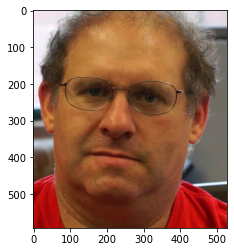

In [4]:
video, fps, video_width, video_height = load_video('face.mp4')
plt.imshow(video[0])
gaussian_pyramids,laplacian_pyramids=generate_image_pyramids(video)

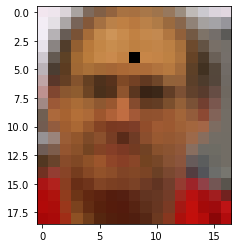

In [5]:
#grab one layer of the gaussian pyramid and select a target pixel to track over all frames.  Forehead works well.

target=gaussian_pyramids[0][5].copy()
target[4,8,:]=0
plt.imshow(target)

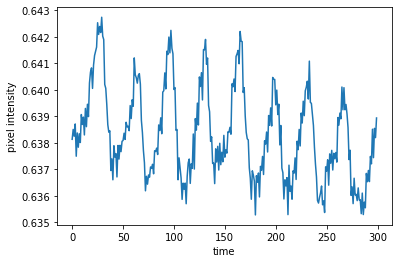

In [6]:
#plot pixel values over time

images_overtime=[gaussian_pyramids[i][5][4,8] for i in range(0,300,1)]  #grab 5th layer of gaussian at pixel (4,8) for all frames
images_overtime=np.asarray(images_overtime)
images_overtime=(images_overtime[:,0]+images_overtime[:,1])/2  #average red and green channels.  blue is noisy.

plt.plot(images_overtime)
plt.xlabel('time')
plt.ylabel('pixel intensity')
plt.show()

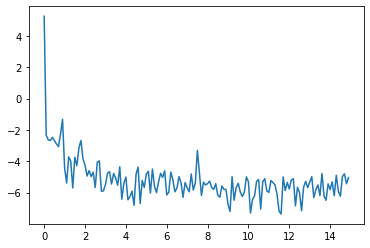

In [7]:
#take Fourrier transform of pixel values

SAMPLE_RATE=30
DURATION=10
N = SAMPLE_RATE * DURATION

yf = fft(images_overtime[:],n=N)
xf = fftfreq(N, 1 / SAMPLE_RATE)

plt.plot(xf[:len(xf)//2], np.log(np.abs(yf[:len(yf)//2])))  #log scale makes peaks easier to see
plt.show()

In [8]:
#focus only on frequencies that the human heart can have and find the most dominant frequency in that range.

peaks,props=find_peaks(yf,distance=None)

low_cutoff=.7 #hertz values for human heartbeat range
high_cutoff=2.8

valid_peaks=[]
for peak in peaks:
    if xf[peak]>low_cutoff and xf[peak]<high_cutoff:
        valid_peaks.append(peak)
        
max_peak=np.abs(yf[valid_peaks]).argmax()

print('Pulse is:',xf[valid_peaks[max_peak]]*60,'bpm')

Pulse is: 54.0 bpm


C:\Users\15178\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
